### Description- This notebook contains code related to image preprocessing.


In [1]:
"""
/* Copyright (C) 2019 Advenio Tecnosys Pvt. Ltd.

*        All Rights Reserved

*

 * NOTICE: 

 * All information contained herein is, and remains

* the property of Advenio Tecnosys and its suppliers,

* if any.  The intellectual and technical concepts contained

* herein are proprietary to Advenio Tecnosys

* and its suppliers and may be covered by Indian, U.S. and Foreign Patents,

* patents in process, and are protected by trade secret or copyright law.

* Appropriation, redistribution, dissemination of this information or reproduction

* of this material is strictly forbidden unless prior written permission is obtained

* from Advenio Tecnosys Pvt. Ltd.

*

* Author: Anjani Suman

*/

"""
 

'\n/* Copyright (C) 2019 Advenio Tecnosys Pvt. Ltd.\n\n*        All Rights Reserved\n\n*\n\n * NOTICE: \n\n * All information contained herein is, and remains\n\n* the property of Advenio Tecnosys and its suppliers,\n\n* if any.  The intellectual and technical concepts contained\n\n* herein are proprietary to Advenio Tecnosys\n\n* and its suppliers and may be covered by Indian, U.S. and Foreign Patents,\n\n* patents in process, and are protected by trade secret or copyright law.\n\n* Appropriation, redistribution, dissemination of this information or reproduction\n\n* of this material is strictly forbidden unless prior written permission is obtained\n\n* from Advenio Tecnosys Pvt. Ltd.\n\n*\n\n* Author: Anjani Suman\n\n*/\n\n'

### Importing Library 

In [2]:
#from preprocess import *
import os
import cv2
import numpy as np
import peakutils
import math
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import enhance_denoise as ED
from PIL import Image
import pandas as pd
from enhance_denoise import Timer
from keras.preprocessing.image import img_to_array,array_to_img
import shutil

Using TensorFlow backend.


### Normalization

In [3]:
def NormalizeSingle(img, lambda_avg):
    
    count = len(lambda_avg)

    h_size = 2
    sigma = 0.5

    IO = img.copy()
    IO1 = img.copy()
    rows, cols = img.shape
    I = np.zeros((rows, cols, count))

    # Convolutions
    for i in range(count):
        kernelX = cv2.getGaussianKernel(h_size, 0.5).astype(np.float64)
        kernel = kernelX * kernelX.T

        temp = convolve2d(IO, kernel, "same")

        I[:,:,i] = temp.copy()
        h_size = h_size + 1
        sigma = sigma + 0.5
        IO = temp.copy()

    temp = convolve2d( I[:,:,count-1], kernel, "same")
    
    Ifreq = np.zeros((rows, cols, count))

    # Difference of Gaussian
    for k in range(count):
        temp1 = I[:,:,k]
        Ifreq[:,:,k] = IO1 - temp1
        IO1 = I[:,:,k]
    
    I1 = temp
    
    # Normalize
    for k in reversed(range(count)):
        f1 = Ifreq[:,:,k]
        temp2 = I1 + (f1 * lambda_avg[k])

        temp2 = 255 * (temp2 - np.min(temp2.ravel())) / np.max(temp2.ravel() - np.min(temp2.ravel()))
        I1 = temp2

    # /*round off values of arma mat*/
    imNorm1 = np.round(I1)
    
    return imNorm1.copy()

In [4]:
def NormalizeImage(img):
    img = img.astype(np.float64)

    lvalueg = np.array([0.292761914578325, 0.364846438109161, 0.409420565254059])

    lvaluer = np.array([0.275757818668329, 0.355687956171273, 0.382670600656154])

    # /*perform normalization on green and red channel*/
    Ign = NormalizeSingle(img[:,:,1], lvalueg)
    Irn = NormalizeSingle(img[:,:,2], lvaluer)

    norm_img = img.copy()
    norm_img[:,:,1] = Ign
    norm_img[:,:,2] = Irn

    return norm_img


###  CLAHE Implementation

In [5]:
def clahe(img, clip_limit, tile_grid_size):
    try:  
        enhanced_img = np.zeros(img.shape)
    except Exception:  
        return None  # if img is not an image


    clahe_obj = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    #img=cv2.cvtColor(img.copy(), cv2.COLOR_BGR2LAB)
    enhanced_img = img.copy()
    for i in range(0,1):
        try:  
            enhanced_img[:, :] = clahe_obj.apply(img[:, :])
        except Exception:  
            return None  # if no_of_channels != 3

    #enhanced_img=cv2.cvtColor(enhanced_img.copy(), cv2.COLOR_LAB2BGR)
    return enhanced_img


### Cropping the Image

In [6]:
def __crop_minAreaRect(img, rect):
    # rotate img
    angle = rect[2]
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    pts[pts < 0] = 0
    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1], 
                       pts[1][0]:pts[2][0]]        
    return img_crop


### mask_crop_adaptive_rotate

In [51]:
def mask_crop_adaptive_rotate(img, bins=256):

    # con_green = clahe(img[:,:,1], 1.2, tile_grid_size=(8,8))
    con_green = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    con_green = clahe(con_green, 1.2, tile_grid_size=(8,8))

    #hist = ([con_green], [0], None, [bins], [0, 256])
    hist,binn = np.histogram(con_green,256,[0,256])
    # Invert the histogram (minima will become maxima and vice versa)
    hist_inv = hist.max() - hist
    indexes = peakutils.indexes(hist_inv.flatten())
    indexes=np.sort(indexes)

    # First maxima (i.e. first minima in original histogram)
    thresh_vals = np.linspace(0, 256, num=bins)
    thresh_mask = thresh_vals[indexes[0]]
    
    _, thresh = cv2.threshold(con_green, thresh_mask, 255, cv2.THRESH_BINARY)
    
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours,hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(contours)
    
    contours_area = [cv2.contourArea(contour) for contour in contours]

    # Max area contour in our case is Fundus
    max_contour_area_index = np.array(contours_area).argmax()
    x, y, w, h = cv2.boundingRect(contours[max_contour_area_index])
    mask = np.zeros_like(img)
    mask = cv2.drawContours(img,contours,max_contour_area_index,(1,1,1),-1)
    plt.imshow(mask)
#     rot_box = cv2.minAreaRect(contours[max_contour_area_index])
#     img_cropped = __crop_minAreaRect(img, rot_box)
#     mask_cropped = __crop_minAreaRect(mask, rot_box)

#     masked = cv2.multiply(img_cropped, mask_cropped)

#     # Contour Properties
#     perimeter = cv2.arcLength(contours[max_contour_area_index], True)
#     area = cv2.contourArea(contours[max_contour_area_index])

#     equi_diameter = np.sqrt(4*area/np.pi)
#     circularity = 4*math.pi*(area/(perimeter*perimeter))

#     rect_area = w*h
#     extent = float(area)/rect_area

#     aspect_ratio = w/h

#     try:
#         (x,y),(MA,ma),angle = cv2.fitEllipse(contours[max_contour_area_index])
#     except:
#         (x,y),(MA,ma),angle = (None, None), (None, None), None

#     return masked, mask_cropped, circularity, equi_diameter, extent, aspect_ratio, MA, ma, angle, hist, thresh_vals,mask

[array([[[ 290,    0]],

       [[ 290,    2]],

       [[ 289,    3]],

       ...,

       [[1191,    1]],

       [[1190,    1]],

       [[1189,    0]]], dtype=int32)]


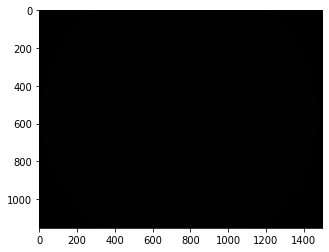

In [52]:
mask_crop_adaptive_rotate(cv2.imread('enhanced_img.png'))

### Preprocessing of Image

In [29]:
def preprocess(_X):
    '''
    _X :: 8UC3, BGR
    returns :: 8UC3, BGR
    '''
    X_hsv = cv2.cvtColor(_X, cv2.COLOR_BGR2HSV_FULL)
    V = X_hsv[:, :, 2].copy()
    V_f = V.astype(np.float64)
    V_norm = np.ones_like(V_f)
    V_norm  = cv2.normalize(V_f, V_norm, 0.0, 1.0, cv2.NORM_MINMAX, cv2.CV_64F)
    V_norm_int = (V_norm * 255).astype(np.uint8)
    X_hsv[:,:,2] = V_norm_int
    Y = cv2.cvtColor(X_hsv, cv2.COLOR_HSV2BGR_FULL)
    return Y

### Resize by Maintaining aspect ratio

In [30]:
# def resize(img, size, padColor=0):
#     h, w = img.shape[:2]
#     sh, sw = size

#     # interpolation method
#     if h > sh or w > sw: # shrinking image
#         interp = cv2.INTER_AREA

#     else: # stretching image
#         interp = cv2.INTER_CUBIC

#     # aspect ratio of image
#     aspect = float(w)/h 
#     saspect = float(sw)/sh

#     if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
#         new_h = sh
#         new_w = np.round(new_h * aspect).astype(int)
# #         pad_horz = float(sw - new_w) / 2
# #         pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
# #         pad_top, pad_bot = 0, 0

#     elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
#         new_w = sw
#         new_h = np.round(float(new_w) / aspect).astype(int)
# #         pad_vert = float(sh - new_h) / 2
# #         pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
# #         pad_left, pad_right = 0, 0

#     # set pad color
# #     if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
# #         padColor = [padColor]*3

#     # scale and pad
#     scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
#     #scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

#     return scaled_img


### White area removal by binary thresholding 

In [31]:

# def white_area_remove(img_hi2):
#     #img_hi2=cv2.imread('f1_edited.png')

#     #plt.imshow(img_hi2)
#     #img_hi2_c=img_hi2.copy()
#     img_hi=cv2.cvtColor(img_hi2,cv2.COLOR_BGR2GRAY)

#     ### CLAHE for histogram equilizer 
#     clahe_obj = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
#     con_green=clahe_obj.apply(img_hi)

#     ## Plotting histogram 
#     #plt.hist(con_green.flat,bins=10,range=(0,255))

#     ### Here threshhold is 210 
#     ret,thersh_1=cv2.threshold(img_hi,210,255,cv2.THRESH_BINARY)

#     ### OTSU automatically finds the threshold without histogram
#     #ret,thersh_1=cv2.threshold(img_hi,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     ### It gives the threshold value
#     #print(ret)

#     #plt.imshow(thersh_1)

#     ### Converting GRAY to BGR 
#     thersh_1=cv2.cvtColor(thersh_1,cv2.COLOR_GRAY2BGR)

#     ### Masking the image with threshold values 
#     masked = cv2.subtract(img_hi2,thersh_1)
    
#     masked_img, mask, circularity, equi_diameter, extent, aspect_ratio, MA, ma, angle, hist, threshold = mask_crop_adaptive_rotate(masked, bins=50)

    
# #     titles = ['Image','Masked']
# #     images = [img_hi2,masked_img]
# #     for i in range(len(images)):
# #         plt.subplot(2, 2, i+1), plt.imshow(images[i], 'gray')
# #         plt.title(titles[i])
# #         plt.xticks([]),plt.yticks([])

# #     plt.show()
    
# #     cv2.imshow('masked',masked)
# #     cv2.imshow('Original Image',img_hi2)
# #     cv2.waitKey(0)
# #     cv2.destroyAllWindows()

# #     plt.imshow(masked)

#     #cv2.imwrite('after_white_removed_1_hsv-org.png',masked_img)
#     return masked_img

### Prepare Image Files

[array([[[ 296,    0]],

       [[ 294,    2]],

       [[ 293,    2]],

       ...,

       [[1188,    1]],

       [[1187,    1]],

       [[1186,    0]]], dtype=int32)]
aspect_ratio = 1.2361111111111112


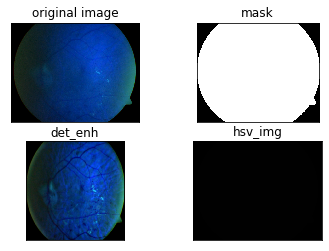

In [35]:
def prep_image():
    
    img = cv2.imread('enhanced_img.png')
    
            # Contrast 50 Bins
    masked_img, mask, circularity, equi_diameter, extent, aspect_ratio, MA, ma, angle, hist, threshold,mask_im = mask_crop_adaptive_rotate(img, bins=50)
        #outdir = os.path.dirname(path)
#         mask_dir = outdir + "/Gray_Contrast_Mask50/"
#         os.makedirs(mask_dir, exist_ok=True)
#         cv2.imwrite(mask_dir + file + "_mask.png",mask * 255)
        
#     cv2.imwrite ('_mask.png',mask*255)
    print("aspect_ratio =",aspect_ratio)
    #masked_img=cv2.cvtColor(masked_img,cv2.COLOR_BGR2RGB)    
    m_img = cv2.resize(masked_img, (512, 512)) 
    #m_img=image_resize(masked_img,width = 512, height = 512)
    #m_img=resizeAndPad(masked_img,(512,512))
    #white_area_remove(preprocess(masked_img))
    
#         prep_dir = outdir + "/HSV_eq/"
#         os.makedirs(prep_dir, exist_ok=True)
#         cv2.imwrite(prep_dir + file+"_hsv_img.png", preprocess(m_img))
    #cv2.imwrite('unpf1ap_hsv_img.png',preprocess(m_img))

        # cv2.imwrite('masked.png', masked_img)
#         det_dir = outdir + "/detail_enhance/"
#         os.makedirs(det_dir, exist_ok=True)
    enh_img = ED.enhance_fundus_denoise(m_img)[2]
#     cv2.imshow("enh_image",enh_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#         cv2.imwrite(det_dir + file+"_det_enh.png", enh_img)

#     cv2.imwrite('_det_enh.png',enh_img)
        # rez_enh_img = cv2.resize(enh_img, (512,512))
        # det_img = Image.fromarray(enh_img)
        # det_img.save(det_dir + file+"_det_enh.png")
        
      ##Edge Smoothing using averaging
    
#     pre_img=white_area_remove(preprocess(m_img))
#     pre_img=resize(pre_img,(512,512))
#     kernel = np.ones((5,5),np.float32)/25
#     dst = cv2.filter2D(pre_img,-1,kernel)
#     cv2.imwrite('edge_smoothing.png',dst)    
    
    
    #cv2.imwrite('enh_hsv_img.png', resize(white_area_remove(preprocess(m_img)),(512,512)))

    
#         norm_dir = outdir + "/Normalized/"
#         os.makedirs(norm_dir, exist_ok=True)
#         #print(norm_dir)
#         cv2.imwrite(norm_dir + file+"_norm_img.png", NormalizeImage(m_img))
#     cv2.imwrite('_norm_img.png',NormalizeImage(m_img))
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #thersh_1=cv2.cvtColor(mask*255,cv2.COLOR_GRAY2BGR)
    #img_masked = cv2.subtract(img,thersh_1)
    
    titles = ['original image','mask','det_enh','hsv_img','contour']
    images = [img,mask*255,enh_img,mask_im]
    for i in range(len(images)):
        plt.subplot(2, 2, i+1), plt.imshow(images[i], 'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()
    
prep_image()

In [42]:
img = cv2.imread('enhanced_img.png', 0)

ret, thres = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
c, h = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

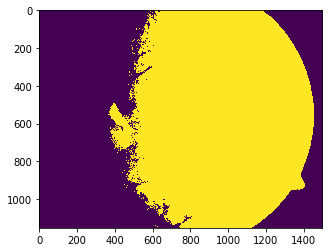

In [45]:
plt.imshow(thres)

In [12]:
# #### Maintaining aspect ratio 
# def crop_and_resize(img, w, h):
#         im_h, im_w, channels = img.shape
#         print(channels)
#         res_aspect_ratio = w/h
#         input_aspect_ratio = im_w/im_h

#         if input_aspect_ratio > res_aspect_ratio:
#             im_w_r = int(input_aspect_ratio*h)
#             im_h_r = h
#             img = cv2.resize(img, (im_w_r , im_h_r))
#             x1 = int((im_w_r - w)/2)
#             x2 = x1 + w
#             img = img[:, x1:x2, :]
#         if input_aspect_ratio < res_aspect_ratio:
#             im_w_r = w
#             im_h_r = int(w/input_aspect_ratio)
#             img = cv2.resize(img, (im_w_r , im_h_r))
#             y1 = int((im_h_r - h)/2)
#             y2 = y1 + h
#             img = img[y1:y2, :, :]
#         if input_aspect_ratio == res_aspect_ratio:
#             img = cv2.resize(img, (w, h))

#         return img

In [13]:
# img = cv2.imread('f1.jpg')
# plt.imshow(crop_and_resize(img, 512, 512))

In [14]:
# cv2.imwrite('maintaining_aspect_ratio.png',crop_and_resize(img, 512, 512))

In [15]:
# def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
#     # initialize the dimensions of the image to be resized and
#     # grab the image size
#     dim = None
#     (h, w) = image.shape[:2]

#     # if both the width and height are None, then return the
#     # original image
#     if width is None and height is None:
#         return image

#     # check to see if the width is None
#     if width is None:
#         # calculate the ratio of the height and construct the
#         # dimensions
#         r = height / float(h)
#         dim = (int(w * r), height)

#     # otherwise, the height is None
#     else:
#         # calculate the ratio of the width and construct the
#         # dimensions
#         r = width / float(w)
#         dim = (width, int(h * r))

#     # resize the image
#     resized = cv2.resize(image, dim, interpolation = inter)

#     # return the resized image
#     return resized

In [16]:
# img = cv2.imread('f1.jpg')

In [17]:
# cv2.imwrite("reszied_image.png",image_resize(img, width = 512, height = 512))

In [1]:
#import cv2 as cv
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import peakutils

In [2]:
# img_seg=cv2.imread('wpf1.jpg')
img_seg = cv2.imread("enhanced_img.png")

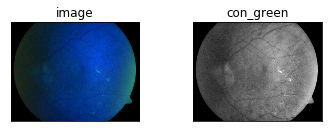

In [4]:
con_green = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
clahe_obj = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
con_green=clahe_obj.apply(con_green)
titles = ['image', 'con_green']
images = [img_seg, con_green]
for i in range(2):
    plt.subplot(2, 2, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [7]:
hist,binn = np.histogram(con_green,256,[0,256])
 
## Plotting histogram 
plt.hist(con_green.flat,bins=10,range=(0,255))
 
hist_inv = hist.max() - hist
#print(hist_inv)
indexes = peakutils.indexes(hist_inv.flatten())
#print(indexes)
indexes=np.sort(indexes);indexes
 
thresh_vals = np.linspace(0, 256, num=256)
#print(thresh_vals)
thresh_mask = thresh_vals[indexes[0]]; thresh_mask
 
ret, thresh = cv2.threshold(con_green, thresh_mask, 255, cv2.THRESH_BINARY)
print(ret)
 
#plt.imshow(thresh)
#ret,thresh=cv2.threshold(con_green,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#print(ret) 
 
kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
 
### morphological opening operations are performed here 
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
 
contours,hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_area = [cv2.contourArea(contour) for contour in contours]
 

### length of contours
len(contours)
 
#plt.imshow(cv2.drawContours(img_seg,contours,-1,(0,255,0),3))
 
# Max area contour in our case is Fundus
max_contour_area_index = np.array(contours_area).argmax()
#print(max_contour_area_index)
x, y, w, h = cv2.boundingRect(contours[max_contour_area_index])
print(x,y,w,h)
mask = np.zeros_like(img_seg)
mask = cv2.drawContours(mask,contours,max_contour_area_index,(1,1,1),-1)
 
plt.imshow(mask)
titles = ['thresh', 'mask']
images = [thresh, mask]
 
for i in range(len(images)):
    plt.subplot(2, 2, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
 
# Mask Overlayed Image
img_mask_overlay = cv2.drawContours(img_seg.copy(),contours,max_contour_area_index,(0,255,0),3)
 

plt.imshow(img_mask_overlay)


SyntaxError: invalid character in identifier (<ipython-input-7-7c4887c7ecbf>, line 2)